## Fetch data, preprocess and partition to train/test sets
This notebook requires only the file **kinases.csv** that contains IDs for all 797 kinases. It uses _chembl API_ to download data (a really slow procedure) or load from previously created files. Please set value for `DOWNLOAD` accordingly. It proceeds with data filtering and partitioning to train-test sets for fair evaluation. What misses this script is the calculation of fingerprints using RDkit because of inconsistency with python versions.

### 0. Prerequisites

In [1]:
from chembl_webresource_client.new_client import new_client
import csv
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

DOWNLOAD = False # True #   
N=100 # min number of interactions to select per target

Targets=[]
Interactions = []
targets_to_compounds = dict()
with open('kinases.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        Targets.append(row[0])
        targets_to_compounds[row[0]] = []

### 1a. Download data
For every target we create a set of _interactions_. Every interaction is a list containing the compound-ID, the type of metric (IC50, Inhibition etc) and the value. We fetch only those activities that have positive values, i.e. `standard_value__isnull=False`

We also create a tab-separated-values file, one line per activity, containing the information **Target-ID, Compound-ID, Type, Value**.

In [2]:
if DOWNLOAD:
    activity = new_client.activity
    count = 0
    for current in Targets:
        activities = activity.filter(target_chembl_id=current,standard_value__isnull=False).only('molecule_chembl_id','standard_type','standard_value')
#         targets_to_compounds[current]=set()
        for x in activities:
            targets_to_compounds[current].append( x['molecule_chembl_id'].encode("ascii") )
            Interactions.append( [ current,x['molecule_chembl_id'].encode("ascii"), x['standard_type'].encode("ascii"),x['standard_value'].encode("ascii")] )
        count+=1
        if count%50==0:print("More than %d targets are processed" % count)

    with open("interactions_kinases_val.tab", 'w') as file:
        file.write("Target\tCompound\tType\tValue\n")
        for x in Interactions:
            file.write("{0}\t{1}\t{2}\t{3}\n".format(x[0],x[1],x[2],x[3]) )

#### Get SMILES for each compound in the data set
After getting all the interactions, assign SMILES to the compounds and write to disk. If a compound doesn't have such a representation, assign it with "None". _After this cell, one would normally need the script to calculate fingerprints using RDkit_.

In [3]:
if DOWNLOAD:
    Compounds = set(x[1] for x in Interactions) # we work for all the compounds available in the data set 
    Compounds = list( Compounds )

    molecule = new_client.molecule

    NoSmile=[]
    Smiles=dict()
    # save = open("Compound_SMILES_"+str(len(Compounds))+".tab", 'w')
    save = open("Compound_SMILES.tab", 'w')
    # save.write("Compound-ID\tSMILES\tFingerprint\n")
    for i in range(len(Compounds)):    
        m = molecule.get( Compounds[i] )
        if m['molecule_structures'] is None:
            NoSmile.append(Compounds[i])
            smi="None"
        else:
            smi=m['molecule_structures']['canonical_smiles']
        Smiles[Compounds[i]] = smi
        save.write( Compounds[i]+"\t"+smi+"\t"+"\n" )
    save.close()
    
    print("No SMILES were found for %d compounds!" % len(NoSmile))
    with open('NoSMILES.txt','w') as f:
        for mol in NoSmile:
            f.write(mol+'\n')

### 1b. Or load data from the disk

In [4]:
if ~DOWNLOAD:    
    Interactions = []
    with open("interactions_kinases_all.tab", 'r') as file:
        first_line = file.readline()
        for line in file:
            tokens = line.split('\t')
            # each line is "Target Compound Type Value"
            Interactions.append( [tokens[0], tokens[1],tokens[2], float(tokens[3])] )
#             targets_to_compounds[ line.split()[0] ].append( line.split()[1] ) # we dont need this probably....
    
    Fingerprints=dict()
    with open("Compound_Fingerprints.tab") as file:
        for line in file:
            tokens = line.split()
            Fingerprints[tokens[0]] = tokens[2]
#             if tokens[2] != "NOFP":
#                 Fingerprints[tokens[0]]=tokens[2]
    print("%d fingerprints were loaded!" % len(Fingerprints))

155165 fingerprints were loaded!


### 2. Process
Continue by counting the total number of compounds and other statistics.

In [5]:
Compounds = set()
for x in Interactions:
    Compounds.add(x[1])
Compounds = list(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(len(Targets),len(Compounds),len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/len(Targets)/len(Compounds) ))

Types=dict()
for x in Interactions:
    if x[2] in Types:
        Types[ x[2] ] += 1
    else:
        Types[ x[2] ] = 1
        
vals = Types.values()
vals.sort(reverse=True)
labels = [Types.keys()[Types.values().index(x)] for x in vals]

print('Type of activity with the most occurencies:')
best = Types.keys()[ Types.values().index( max(Types.values())) ]
print(best, Types[best])

There are 797 targets and 155165 compounds currently loaded with 721400 interactions.
A DTI matrix would be 0.5833% dense!
Type of activity with the most occurencies:
('IC50', 188815)


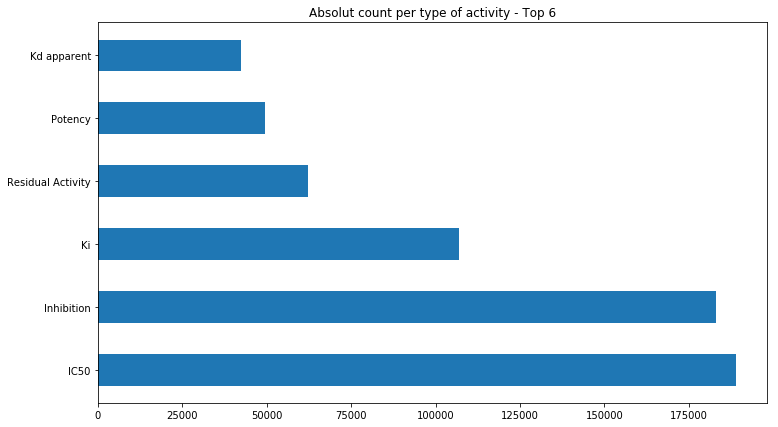

In [6]:
N=6 # number of types to print
fig, ax1 = plt.subplots(figsize=(12, 7))
rects = ax1.barh(range(N), vals[:N], height=0.5, align='center', tick_label=labels[:N])
ax1.set_title("Absolut count per type of activity - Top {0}".format(N))
plt.savefig("activities-all.png")
plt.show()

### 3. Filter targets 
* From the complete list of interactions we select those with IC50 - this has the highest frequency and is saved as `best`. 
* We keep those with compounts for which there is a SMILES representation and IC50<10000

* If there are still duplicates between the same target-compound pair we keep the one with the lowest value. 

* Afterwards, we select only those targets that have at least 100 known interactions.

* We also select only those compounds that share interactions with at least two targets 

    * _The last two steps need to be done iteratively!_

Active is determined as in https://druggablegenome.net/ProteinFam

In [7]:
indices=[]
for i in range(len(Interactions)):
    if Interactions[i][2] == best:
        indices.append(i) 
if len(indices)!=Types[best]: print("Something is wrong!")

# Initialise data-frame by selecting only those activities with "best" type
DF = pd.DataFrame([Interactions[x] for x in indices], columns =['Target-ID', 'Compound-ID', 'Std-type', 'Std-value']) 
DF = DF.drop('Std-type',axis=1) # we omit this column as we have only 1 type now
print("All with IC50 = %d" % DF.shape[0]) # what we have initially

# remove activities with huge values
DF = DF[DF['Std-value']<10000]
print("Upper thres = %d" % DF.shape[0])

# insert a new variable with the smiles for each compound
DF['Fingerprint'] = [Fingerprints[cid] for cid in DF['Compound-ID']]
# remove activities with compounds that dont smile
DF = DF[DF['Fingerprint']!='NOFP']
print("With fingerprint = %d " % DF.shape[0])

# insert a new variable indicating active-decoys
DF['Active'] = [ 1 if float(stdv)<=30 else 0 for stdv in DF['Std-value']]

# Drop duplicate activities keeping the activity with lower concentration for each molecule-target pair
DF.sort_values(by=['Target-ID','Compound-ID','Std-value'], ascending=True)
DF = DF.drop_duplicates(subset=['Target-ID','Compound-ID'], keep='first')
print("No duplicates = %d" % DF.shape[0])

# select compounds with more than 2 interactions:
temp = DF.groupby(['Compound-ID']).agg('count') # count the number of molecules
temp = temp[temp['Active'] > 1] # runs 0:N_compounds - the column 'Active' doesn't matter, we just aggregate
tokeep = [x.encode("ascii") for x in temp.index] # get the IDs
DF = DF[DF['Compound-ID'].isin(tokeep)] # filter-out
print("Filtered 2+ = %d" % DF.shape[0])

# select targets with more than N interactions:
temp = DF.groupby(['Target-ID']).agg('count') # count the number of molecules
temp = temp[temp['Active'] > 100] # runs 0:N_targets - the column 'Active' doesn't matter, we just aggregate
tokeep = [x.encode("ascii") for x in temp.index] # get the IDs
DF = DF[DF['Target-ID'].isin(tokeep)] # filter-out
print("Filtered 100+ = %d" % DF.shape[0])

# filter again for compounds as some have been removed because of last step
temp = DF.groupby(['Compound-ID']).agg('count') # count the number of molecules
temp = temp[temp['Active'] > 1] # runs 0:N_targets - the column 'Active' doesn't matter, we just aggregate
tokeep = [x.encode("ascii") for x in temp.index] # get the IDs
DF = DF[DF['Compound-ID'].isin(tokeep)] # filter-out
print("RE-Filtered 2+ = %d" % DF.shape[0])

# update dataframe:
DF = DF.reset_index(); DF = DF.drop('index', axis=1)

# check for targets with only a few interactions
temp = DF.groupby(['Target-ID']).agg('count') # count the number of molecules
temp = temp[temp['Active'] < 50]
if temp.shape[0]>0:
    print("WARNING: There are targets with less than 50 interactions!")

All with IC50 = 188815
Upper thres = 153223
With fingerprint = 153179 
No duplicates = 129354
Filtered 2+ = 70571
Filtered 100+ = 64134
RE-Filtered 2+ = 62656


In [8]:
# Now print some new statistics for the post-preprocessing data.
Targets = np.unique(DF['Target-ID'])
Compounds = np.unique(DF['Compound-ID'])
print("{0} targets and {1} compounds with a total of {2} interactions have remained.".format(len(Targets),len(Compounds),DF.shape[0]))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*DF.shape[0]/len(Targets)/len(Compounds) ))
print("Number of Actives/Decoys = {0} / {1}".format(np.sum(DF['Active']),sum(DF['Active']<1)) )

temp = DF.groupby(['Target-ID']).agg('count') # count the number of molecules
print("Average # molecules per target = %f" % np.mean(list(temp.iloc[:,1])) ) 

temp = DF.groupby(['Compound-ID']).agg('count') # count the number of molecules
print("Average # targets per molecule = %f" % np.mean(list(temp.iloc[:,1])) ) 

110 targets and 23361 compounds with a total of 62656 interactions have remained.
A DTI matrix would be 2.438% dense!
Number of Actives/Decoys = 21262 / 41394
Average # molecules per target = 569.600000
Average # targets per molecule = 2.682077


### 4. Partition data to train/test sets and save to disk
Since the decoys are far more than the active compounds, in order to make a fair evaluation procedure, we need to select a testing set that is balanced. For that reason we randomly select 5% of the total number from each class to form a balanced validation set with 10% of the total data points. The file with the test set will be _hidden_ until the final evaluation.

In [9]:
random_seed = 2019
np.random.seed(random_seed)

# split = int(np.floor(0.25 * DF.shape[0] ))
active   = [ x for x in range(DF.shape[0]) if DF['Active'][x]==1 ] 
inactive = [ x for x in range(DF.shape[0]) if DF['Active'][x]==0 ] 

# compute the number of items from each case required for balance
split = int(np.floor( 0.05*( len(inactive) + len(active)) ))
# splitB = int(np.floor( 0.1*( len(inactive) + len(active)) ))
print("Number of hidden Active/Decoys = {0} / {1}".format( split, split ))

# split the active interactions in train-test sets
np.random.shuffle( active ) # this happens in-place
train_indices = active[split:]
test_indices  = active[:split]

# do the same for the inactive
np.random.shuffle( inactive ) # this happens in-place
train_indices.extend( inactive[split:] )
test_indices.extend(  inactive[:split] )

# remove unecessary columns
DF = DF.drop(['Fingerprint','Active'], axis=1)

# now partition and save to files
temp = DF.loc[train_indices]
temp.to_csv("interactions_kinases_"+best+"_train.tab", sep='\t', index=None)

temp = DF.loc[test_indices]
temp.to_csv("interactions_kinases_"+best+"_test.tab", sep='\t', index=None)

# check for mistakes
intersect = [x for x in train_indices if x in test_indices]
if len(intersect)>0: 
    print("There are rows shared by both sets...")
else:
    print("The data set is ready!")

Number of hidden Active/Decoys = 3132 / 3132
The data set is ready!


### Appendix - old ways of doing stuff

In [10]:
# DF['Std-value'] = pd.to_numeric( DF['Std-value'] )
# DF = DF.sort_values(by='Std value', ascending=True)

#     current = targets_to_compounds.keys()[i]
#     for x in activities:
#         targets_to_compounds[current].add( x['molecule_chembl_id'].encode("ascii") )#.encode("ascii") )
# #         Interactions.append( [ current,x['molecule_chembl_id'],x['pchembl_value'] ] )
#         Interactions.append( [ current,x['molecule_chembl_id'].encode("ascii") ] )
#     targets_to_compounds[current].add([x['molecule_chembl_id'].encode("ascii") for x in activities])
#     print(current, len(targets_to_compounds[current]))

# # write a file with training data
# with open("interactions_kinases_"+best+"_train.tab", 'w') as file:
#     file.write("Target\tCompound\tType\tValue\n")
#     for indx in train_indices:
#         x = Interactions[indx]
#         file.write("{0}\t{1}\t{2}\t{3}\n".format(x[0],x[1],x[2],x[3]) )

# # write a file with testing data
# with open("interactions_kinases_"+best+"_test.tab", 'w') as file:
#     file.write("Target\tCompound\tType\tValue\n")
#     for indx in test_indices:
#         x = Interactions[indx]
#         file.write("{0}\t{1}\t{2}\t{3}\n".format(x[0],x[1],x[2],x[3]) )

# np.random.shuffle( indices ) # this happens in-place
# train_indices, test_indices = indices[split:], indices[:split]